# 1. Introducction

In this file the Loan_performance.csv dataset will be studied.

It is hypothesized that this dataset is loans that have been made to people in bankruptcy.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

# 2. Understanding raw data and preparation.

## 2.1 Preparation 

In [2]:
df =  pd.read_csv('Loan_performance.csv')
df.head()

,analytics_matchkey,max_loan_amount,late_30_days,late_60_days,late_90_days
0,1346745,2500,0,0,0
1,1346746,1000,0,0,0
2,1346747,1002,0,0,0
3,1346748,1500,0,0,0
4,1346749,1675,0,0,0


It is verified that for all cases, if it has been delayed more than 90 days it has also been delayed more than 60 and 30 days, in the same way it is verified that for more than 60 days it has also been delayed more than 30.

Doing this check verifies that the data is in order.

In [3]:
condition1 = df[df['late_60_days'] == 1]['late_30_days'].eq(1).all()
condition2 = df[df['late_90_days'] == 1][['late_30_days', 'late_60_days']].eq(1).all().all()

print(f"Condition 1 (late_60_days -> late_30_days): {condition1}")
print(f"Condition 2 (late_90_days -> late_30_days and late_60_days): {condition2}")

Condition 1 (late_60_days -> late_30_days): True
Condition 2 (late_90_days -> late_30_days and late_60_days): True


It is understood that if the variables late_90_day slate_30_days late_60_days represent a delay, so if they are 0 there is no delay.

This information is added in the form of a new variable.

In [4]:
df['no_late'] = 0
df.loc[(df['late_30_days'] == 0) & (df['late_60_days'] == 0) & (df['late_90_days'] == 0), 'no_late'] = 1
df.loc[df['late_90_days'] == 1, ['late_30_days', 'late_60_days']] = 0
df.loc[df['late_60_days'] == 1, 'late_30_days'] = 0


df.head()

,analytics_matchkey,max_loan_amount,late_30_days,late_60_days,late_90_days,no_late
0,1346745,2500,0,0,0,1
1,1346746,1000,0,0,0,1
2,1346747,1002,0,0,0,1
3,1346748,1500,0,0,0,1
4,1346749,1675,0,0,0,1


## 2.2 Basic Statistics 

In [5]:
df_melted = pd.melt(df, id_vars=['analytics_matchkey','max_loan_amount'], value_vars=['late_30_days', 'late_60_days', 'late_90_days', 'no_late'],
                    var_name='category', value_name='value')

df_filtered = df_melted[df_melted['value'] == 1]
stat_summary = df_filtered.groupby('category')['max_loan_amount'].describe()
print(stat_summary)

                 count         mean         std     min     25%     50%  \
category                                                                  
late_30_days   19390.0  1739.138886  718.919738  1000.0  1176.0  1500.0   
late_60_days    6434.0  1719.555486  698.610873  1000.0  1152.5  1500.0   
late_90_days   52725.0  1719.517876  748.176936  1000.0  1100.0  1400.0   
no_late       567578.0  1745.062125  729.963845  1000.0  1183.0  1500.0   

                 75%     max  
category                      
late_30_days  2075.0  4000.0  
late_60_days  2075.0  4000.0  
late_90_days  2100.0  4000.0  
no_late       2076.0  4000.0  


You can start to draw conclusions, there is a great discrepancy in the data, the most frequent being no_late.

The average are very similar. They are all within one standard deviation of each other. 

## 2.3 Data visualization

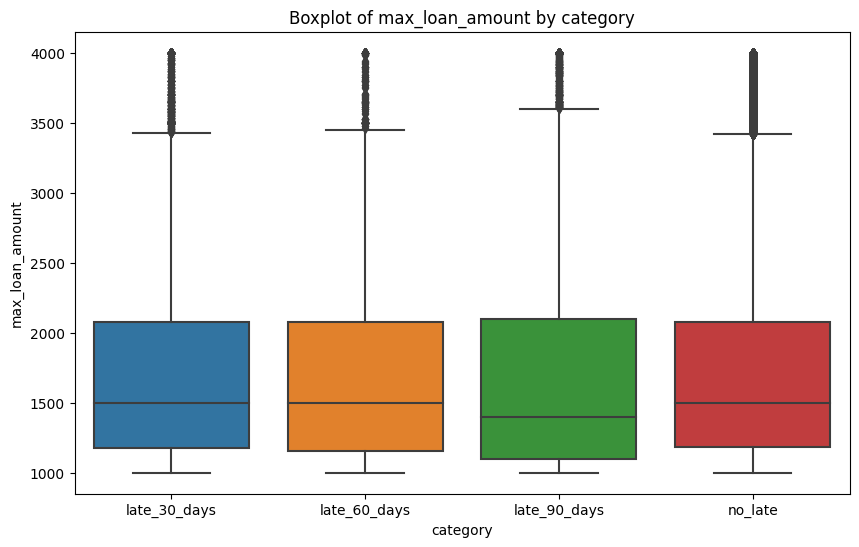

In [6]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='max_loan_amount', data=df_filtered)
plt.title('Boxplot of max_loan_amount by category')
plt.show()

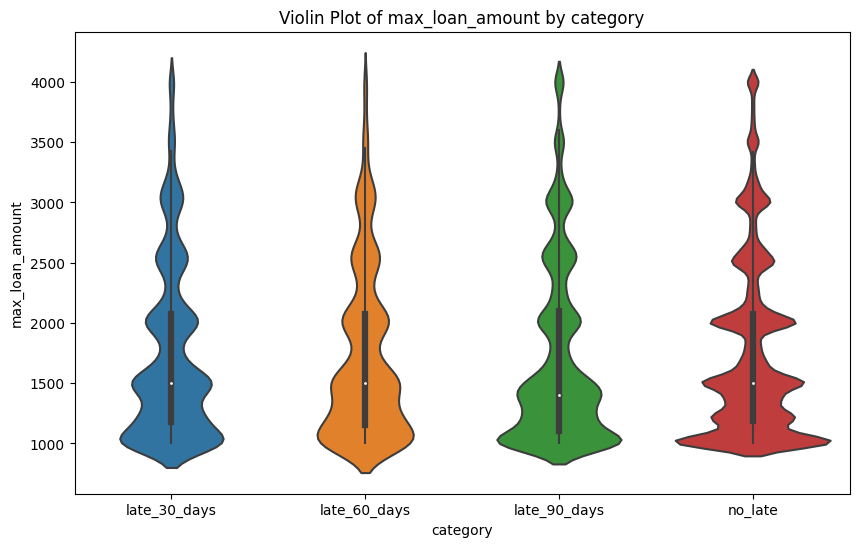

In [7]:
# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='category', y='max_loan_amount', data=df_filtered)
plt.title('Violin Plot of max_loan_amount by category')
plt.show()

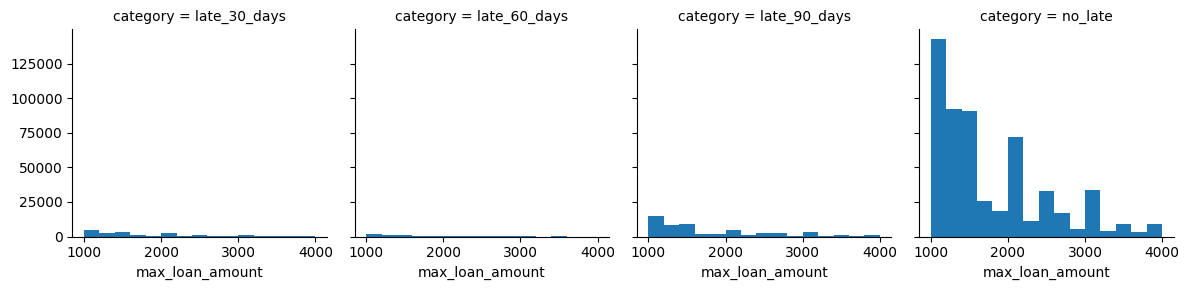

In [8]:
# Histogram by category
g = sns.FacetGrid(df_filtered, col='category')
g.map(plt.hist, 'max_loan_amount', bins=15)
plt.show()

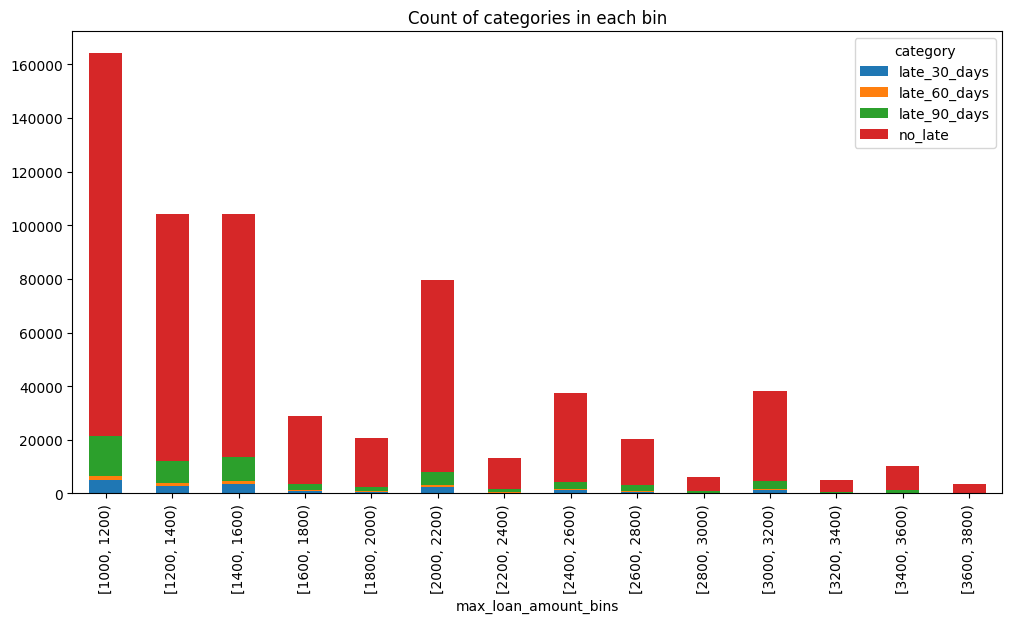

In [9]:
# Make bins each 1000 in max_loan_amount
new_df = df_filtered.copy()
new_df['max_loan_amount_bins'] = pd.cut(df_filtered['max_loan_amount'], bins=range(1000, 4000, 200), right=False)

# Count each category in each bin
df_grouped = new_df.groupby(['category', 'max_loan_amount_bins']).size().unstack().fillna(0)

# Transpose the DataFrame
df_grouped = df_grouped.T
# Histogram of bins
df_grouped.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Count of categories in each bin')
plt.show()


Smaller loans have a lower chance of late or non-payment.

## 2.4 Statistical analysis using ANOVA

In [10]:
# ANOVA
model = sm.OLS.from_formula('max_loan_amount ~ C(category)', data=df_filtered)
results = model.fit()
anova_results = anova_lm(results)

anova_results

,df,sum_sq,mean_sq,F,PR(>F)
C(category),3.0,3.517892e+07,1.172631e+07,21.954526,3.283413e-14
Residual,646123.0,3.451059e+11,5.341179e+05,NaN,NaN


The result of the anova indicates that there are statistical differences between the means, this is probably due to the large amount of data there is, perhaps due to its imbalance. 

In [11]:
df.to_csv('Loan_performance_transformed.csv')